In [9]:
import os
import pickle
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import warnings
import datetime as dt
import yfinance as yf

# Keras / TensorFlow imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

rcParams['figure.figsize'] = 12,6
warnings.filterwarnings('ignore')

# Chọn mã cổ phiếu phù hợp với tên notebook
bank_stock_name = "STB.VN"

# Thư mục lưu model
model_dir = os.path.join(os.getcwd(), '..', 'Save_model')
stock_model_dir = os.path.join(model_dir, bank_stock_name)
print('Model dir:', stock_model_dir)
if not os.path.exists(stock_model_dir):
    os.makedirs(stock_model_dir, exist_ok=True)


Model dir: c:\Users\Dell\Documents\BIG_DATA_NHOM\Train_model\..\Save_model\STB.VN


In [10]:
def save_keras_model(stock_model_dir,model_name, model):
    model_name = model_name + ".h5"
    model_path = os.path.join(stock_model_dir, model_name)
    model.save(model_path)
    print(f"Saved model to {model_path}")

def load_keras_model(stock_model_dir, model_name):
    from keras.models import load_model
    model_name = model_name + ".h5"
    model_path = os.path.join(stock_model_dir, model_name)
    model = load_model(model_path)
    print(f"Loaded model from {model_path}")
    return model

def update_model_loss(stock_model_dir, model_name, rmse, mae, r2):
    model_loss_log = os.path.join(stock_model_dir, "model_loss.json")
    loss_detail = {
        "rmse": rmse,
        "mae": mae,
        "r2": r2,
    }
    try:
        with open(model_loss_log, 'r') as f:
            model_loss = json.load(f)
    except:
        model_loss = {}
    model_loss[model_name] = loss_detail

    with open(model_loss_log, 'w') as f:
        json.dump(model_loss, f, indent=4, ensure_ascii=False)

In [11]:
stock = pd.read_csv(f'../data/{bank_stock_name}.csv')
stock.head()

,Price,Date,Close,High,Low,Open,Volume
0,0,2023-07-17,28000.0,28900.0,28000.0,28850.0,41755400
1,1,2023-07-19,28250.0,28600.0,28200.0,28450.0,11967700
2,2,2023-07-20,27850.0,28300.0,27600.0,28250.0,27303420
3,3,2023-07-21,28750.0,28750.0,27800.0,27950.0,30065860
4,4,2023-07-24,28700.0,28900.0,28450.0,28750.0,17377080


# Xây dựng mô hình LSTM

In [12]:
stock.index=stock['Date']

stock.sort_index(ascending=True, axis=0)

stock

,Price,Date,Close,High,Low,Open,Volume
Date,,,,,,,
2023-07-17,0,2023-07-17,28000.0,28900.0,28000.0,28850.0,41755400
2023-07-19,1,2023-07-19,28250.0,28600.0,28200.0,28450.0,11967700
2023-07-20,2,2023-07-20,27850.0,28300.0,27600.0,28250.0,27303420
2023-07-21,3,2023-07-21,28750.0,28750.0,27800.0,27950.0,30065860
2023-07-24,4,2023-07-24,28700.0,28900.0,28450.0,28750.0,17377080
...,...,...,...,...,...,...,...
2025-11-19,575,2025-11-19,49500.0,50300.0,49050.0,49450.0,12959060
2025-11-20,576,2025-11-20,49500.0,49800.0,49100.0,49500.0,9327484
2025-11-21,577,2025-11-21,51300.0,51300.0,48900.0,49050.0,10156660


In [13]:
PAST_RANGE = 80

#creating dataframe
stock_lstm = pd.DataFrame(index=range(0,len(stock)),columns=['Date', 'Close'])
for i in range(0,len(stock)):
    stock_lstm['Date'][i] = stock['Date'][i]
    stock_lstm['Close'][i] = stock['Close'][i]

#setting index
stock_lstm.index = stock_lstm.Date
stock_lstm.drop('Date', axis=1, inplace=True)


In [20]:
#creating train and test sets
dataset = stock_lstm.values

train = dataset[0:990,:]
valid = dataset[990:,:]

print(f'Dataset shape: {dataset.shape}')
print(f'Train shape: {train.shape}')
print(f'Valid shape: {valid.shape}')


Dataset shape: (580, 1)
Train shape: (580, 1)
Valid shape: (0, 1)


In [21]:
#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(PAST_RANGE,len(train)):
    x_train.append(scaled_data[i-PAST_RANGE:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))


500/500 - 16s - 33ms/step - loss: 0.0060
Fitting Model
ERROR: Valid set is empty! Using different split.
New train shape: (464, 1), New valid shape: (116, 1)
Inputs shape: (196, 1)
X_test shape before reshape: (116, 80)
X_test shape after reshape: (116, 80, 1)
Fitting Model
ERROR: Valid set is empty! Using different split.
New train shape: (464, 1), New valid shape: (116, 1)
Inputs shape: (196, 1)
X_test shape before reshape: (116, 80)
X_test shape after reshape: (116, 80, 1)
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step
y_valid length: 116, preds length: 116
RMSE: 2526.5069760441984
MAE: 2154.7158203125
R2: 0.6546568870544434

y_valid length: 116, preds length: 116
RMSE: 2526.5069760441984
MAE: 2154.7158203125
R2: 0.6546568870544434



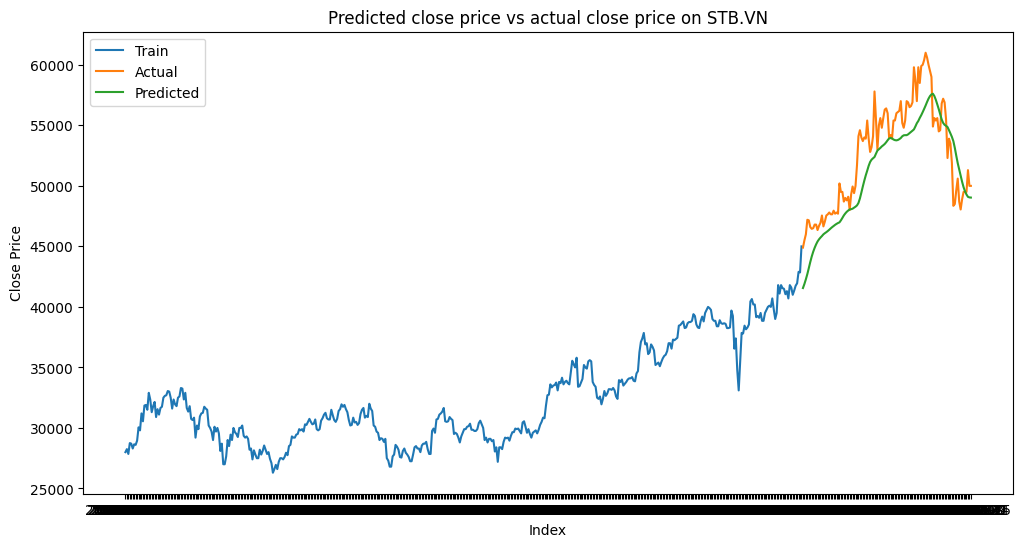

Saved model to c:\Users\Dell\Documents\BIG_DATA_NHOM\Train_model\..\Save_model\STB.VN\LSTM.h5
Model and scaler saved to c:\Users\Dell\Documents\BIG_DATA_NHOM\Train_model\..\Save_model\STB.VN


In [22]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)
print('Fitting Model')

# Check if we have enough data for validation
if len(valid) == 0:
    print("ERROR: Valid set is empty! Using different split.")
    # Use last 20% of data as validation
    split_idx = int(0.8 * len(dataset))
    train = dataset[:split_idx, :]
    valid = dataset[split_idx:, :]
    print(f'New train shape: {train.shape}, New valid shape: {valid.shape}')

# Predicting on validation set
# Need to get the last PAST_RANGE values from training data + all validation data
inputs = dataset[len(dataset) - len(valid) - PAST_RANGE:, :]
print(f'Inputs shape: {inputs.shape}')
inputs = scaler.transform(inputs)

X_test = []
for i in range(PAST_RANGE, len(inputs)):
    X_test.append(inputs[i-PAST_RANGE:i, 0])

X_test = np.array(X_test)
print(f'X_test shape before reshape: {X_test.shape}')

if len(X_test) == 0:
    raise ValueError(f"X_test is empty! Check data: dataset has {len(dataset)} rows, valid has {len(valid)} rows, PAST_RANGE is {PAST_RANGE}")

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print(f'X_test shape after reshape: {X_test.shape}')
closing_price = model.predict(X_test)
preds = scaler.inverse_transform(closing_price).flatten()

# Define y_valid from the valid dataset
y_valid = valid[:, 0]

print(f'y_valid length: {len(y_valid)}, preds length: {len(preds)}')

# Calculate metrics
mse = mean_squared_error(y_valid, preds)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_valid, preds)
r2 = r2_score(y_valid, preds)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R2: {r2}\n')

# For plotting
train_df = stock_lstm[:len(train)]
valid_df = stock_lstm[len(train):len(train)+len(valid)].copy()
valid_df['Predictions'] = preds
plt.figure(figsize=(12, 6))
plt.plot(train_df['Close'], label='Train')
plt.plot(valid_df.index, valid_df['Close'], label='Actual')
plt.plot(valid_df.index, valid_df['Predictions'], label='Predicted')
plt.legend()
plt.title(f'Predicted close price vs actual close price on {bank_stock_name}')
plt.xlabel('Index')
plt.ylabel('Close Price')
plt.show()

# Save model and scaler
save_keras_model(stock_model_dir, "LSTM", model)
update_model_loss(stock_model_dir, "LSTM", rmse, mae, r2)

scaler_path = os.path.join(stock_model_dir, "LSTM_scaler.pkl")
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)
print(f'Model and scaler saved to {stock_model_dir}')
